In [1]:
import torch
import matplotlib.pyplot as plt
from context import *

## Learn from Data

In [2]:
mdl = RGGenerator([1], 1, hdims=[16, 8], hyper_dim=16)
opt = torch.optim.Adam(mdl.parameters(), lr=0.01)

In [3]:
x_dat = torch.tensor([-1.]*50+[1.]*50)
x_dat = x_dat + 0.1*torch.randn_like(x_dat)
x_dat = x_dat[:,None,None]
x_dat.shape

torch.Size([100, 1, 1])

In [13]:
mdl.train()
opt.param_groups[0]['lr'] = 0.001
for _ in range(10):
    opt.zero_grad()
    out = mdl.nll_loss(x_dat, lk=0.01, lg=0.01, atol=1e-3, rtol=1e-3)
    loss = out[0]
    loss.backward()
    opt.step()
    print(*[f'{o.item():5.2f}' for o in out])

 0.60  0.56  1.46  3.06
 0.50  0.46  1.22  2.70
 0.29  0.25  0.91  2.62
 0.15  0.11  0.81  2.58
 0.44  0.41  0.90  2.27
 0.22  0.18  0.98  3.10
 0.15  0.10  1.00  3.12
 0.44  0.41  0.95  2.50
-0.16 -0.20  0.86  3.38
 0.02 -0.02  0.80  3.15


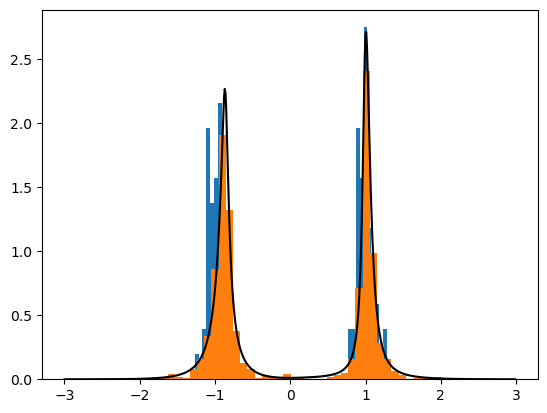

In [14]:
mdl.eval()
x_smp = mdl.sample(1000)
plt.hist(x_dat.squeeze().tolist(), bins=50, density=True);
plt.hist(x_smp.squeeze().tolist(), bins=50, density=True);
xs = torch.arange(-3,3,0.01)
with torch.no_grad():
    ps = mdl.log_prob(xs.view(-1,1,1), div='exact').exp()
plt.plot(xs, ps, 'k-');

## Learn from Energy

In [60]:
mdl = RGGenerator([1], 1, hdims=[16, 8], hyper_dim=16)
opt = torch.optim.Adam(mdl.parameters(), lr=0.01)

In [58]:
def energy(x):
    return torch.squeeze((x-1)**2/(2*(1/3)**2))

In [72]:
mdl.train()
opt.param_groups[0]['lr'] = 0.001
for _ in range(10):
    opt.zero_grad()
    out = mdl.free_loss(energy, 1000, lk=0.01, lg=0.01, atol=1e-3, rtol=1e-3)
    loss = out[0]
    loss.backward()
    opt.step()
    print(*[f'{o.item():5.2f}' for o in out])

 1.71  1.68  1.69  1.55
 1.64  1.61  1.58  1.38
 1.60  1.57  1.61  1.42
 1.63  1.61  1.55  1.41
 1.62  1.59  1.59  1.28
 1.66  1.63  1.52  1.40
 1.73  1.70  1.68  1.38
 1.73  1.70  1.60  1.47
 1.62  1.59  1.61  1.33
 1.65  1.62  1.69  1.31


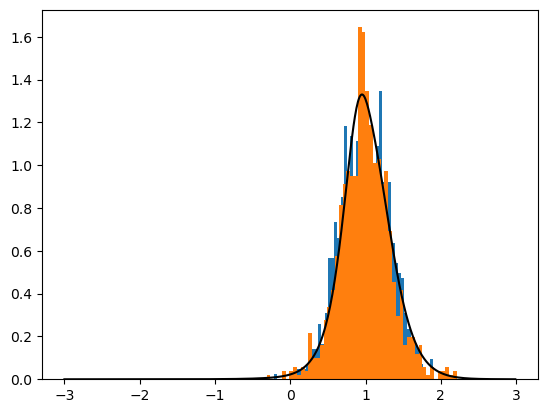

In [73]:
mdl.eval()
x_smp = mdl.sample(1000)
x_dat = torch.randn_like(x_smp)/3+1
plt.hist(x_dat.squeeze().tolist(), bins=50, density=True);
plt.hist(x_smp.squeeze().tolist(), bins=50, density=True);
xs = torch.arange(-3,3,0.01)
with torch.no_grad():
    ps = mdl.log_prob(xs.view(-1,1,1), div='exact').exp()
plt.plot(xs, ps, 'k-');